In [1]:
import seaborn as sns
import pandas as pd
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
from scipy.stats import entropy
from mphelper import ProcessWrapPool
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import itertools
import matplotlib.lines as mlines
from biodatatools.utils.common import json_load

In [2]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9
lw = 0.8

In [3]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_o = "/home/yc2553/projects/HEA/output/"

# Samples

In [4]:
p = "divergent"
ds = ["distal", "proximal"]

In [5]:
labels = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/classifications.json")

In [22]:
all_samples = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/samples.json")["normal_tissues"]

In [41]:
metafile = f"{PROJECT_DIR_o}tables/SuppTable1.xlsx"
df_metrics = pd.read_excel(metafile, sheet_name=2)
reads = {}
for _, row in df_metrics.iterrows():
    reads[row["PRO-cap sample ID"]] = row["Uniquely mapped, deduplicated read pairs"]

In [44]:
samples = [s for s in all_samples if reads[s] >= 10e6]
len(samples)

128

In [9]:
df_exp = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/norm_reads_all.txt", index_col=0)

In [25]:
# Only include elements found in at least one sample tested here
# Need to confirm if this inputfile is reasonable; if not, reprerocess in "1.Data_preprocessing.ipynb" and replace the inputfile here

dfs = {}
for d in ds:
	df = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/binary_{p}_{d}.txt", index_col=0)
	es = list(df[df[samples].sum(axis=1) >= 1].index)
	dfs[(p,d)] = df_exp[samples].loc[es]

# Get specificity scores

In [9]:
# Refer to Fantom5 paper
# Specificity(X) = 1 - (entropy(X)/log2(N)), where X is a vector of sample average expression values for an element over all tissue types and N its cardinality (|X|, the number of tissue types).

In [26]:
# Note that not all tissue types are well clustered

types = defaultdict(list)
for s in samples:
	types[labels[s][1]].append(s)

In [27]:
len(types)

37

In [11]:
def get_specificity(row):
	specificity = 1 - entropy(row, base=2)/np.log2(len(row))
	return specificity

In [12]:
def get_specificity_matrix(df_norm, outputfile):
	results = []
	for index, row in df_norm.iterrows():
		values = []
		for type in types:
			ss = [s for s in samples if labels[s][1] == type]
			values.append(np.mean([row[s] for s in ss]))
		results.append(values)
	df_X = pd.DataFrame(results, columns=types, index=df_norm.index)
	df_X["Specificity"] = df_X.apply(get_specificity, axis=1)
	df_X.to_csv(outputfile, sep="\t")

In [28]:
pwpool = ProcessWrapPool(len(ds))

for d in ds:
	outputfile = f"{PROJECT_DIR_d}PROcap/specificity_{p}_{d}.txt"
	pwpool.run(get_specificity_matrix, args=[dfs[(p,d)], outputfile])

In [29]:
len(pwpool.finished_tasks)

In [16]:
pwpool.close()

# Comparison

## Distal vs. proximal

In [31]:
results = []
for d in ds:
	df = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/specificity_{p}_{d}.txt", index_col=0)
	results.extend([[p, d.capitalize(), score] for score in df["Specificity"]])
df_scores = pd.DataFrame(results, columns=["group1", "group2", "score"])
df_scores.head(2)

,group1,group2,score
0,divergent,Distal,0.080983
1,divergent,Distal,0.381570


In [32]:
palette = ["#CBB1D1", "#CAE5C1"]

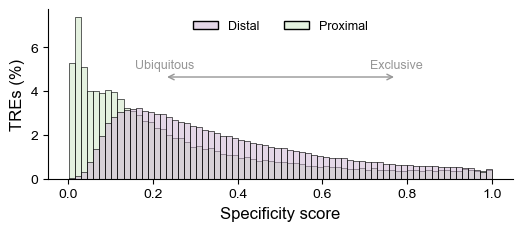

In [34]:
fig, ax = plt.subplots(figsize=(6,2.2))
g = sns.histplot(data=df_scores, x="score", hue="group2",
				 bins=70, palette=palette,
				 stat="percent", common_norm=False,
				 ax=ax
				  )
		
sns.move_legend(
	g, "upper center", ncol=2, title=None, 
	fontsize=sfontsize, frameon=False
)

g.spines[["top", "right"]].set_visible(False)
g.set_xlabel("Specificity score", fontsize=bfontsize)
g.set_ylabel("TREs (%)", fontsize=bfontsize)	

trans = ax.transAxes
g.text(s="Ubiquitous", x=0.25, y=0.65, color="#969696",
			ha="center", fontsize=sfontsize, transform=trans)
g.text(s="Exclusive", x=0.75, y=0.65, color="#969696",
			ha="center", fontsize=sfontsize, transform=trans)
arrow = patches.FancyArrowPatch(
	(0.25, 0.6),      
	(0.75, 0.6),     
	arrowstyle='<->',        
	mutation_scale=10, 
	linewidth=1,
	transform=trans,
	clip_on=False,
	color="#969696"
)
g.add_patch(arrow)

plt.savefig(f"{PROJECT_DIR_o}figures/ExtDataFig3a.pdf", bbox_inches="tight", transparent=True)

## Comparison across tissue types (divergent distal)

In [51]:
# No. elements detected in a given tissue type

n_es = defaultdict(dict)
for d in ds:
	df = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/binary_{p}_{d}.txt", index_col=0)
	for t in types:
		for s in types[t]:
			n_es[d][s] = len(df[df[[s]].sum(axis=1) >= 1].index)

In [53]:
results = []
for t in types:
	for s in types[t]:
		results.append([s, t, reads[s]/1e6, n_es["distal"][s]/1e3, n_es["proximal"][s]/1e3])
df_info = pd.DataFrame(results, columns=["sample", "tissue", "reads", "distal", "proximal"])
df_info.head(2)

,sample,tissue,reads,distal,proximal
0,GT16,Adipose,30.106384,18.326,18.760
1,EN28,Adrenal gland,38.956598,23.850,21.615


In [54]:
# Divide elements into equally-spaced bins based on specificity
# bin 1: most ubiquitous
# bin N: most exclusive

n_bins = 10
bins = np.linspace(0, 1, n_bins+1) 
lbs = range(1, n_bins+1)
df_bins = {}
for d in ds:
	df_bins[d] = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/specificity_{p}_{d}.txt", index_col=0)
	df_bins[d]["Bin"] = pd.cut(df_bins[d]["Specificity"], bins=bins, labels=lbs, include_lowest=True)

In [55]:
df_frac = {}
for d in ds:
	results = []
	for t in types:
		# Focus on elements found in samples of a given tissue type
		df = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/binary_{p}_{d}.txt", index_col=0)
		es = list(df[df[types[t]].sum(axis=1) >= 1].index)
		counts = Counter(df_bins[d].loc[es]["Bin"])
		row = [counts[n]/len(es) for n in range(1,n_bins+1)]
		results.append(row)
	df_frac[d] = pd.DataFrame(results, columns=[n for n in range(1,n_bins+1)], index=types).T

In [56]:
# Sort the tissue types by weighted fraction (the larger the number, the higher fraction of specific TREs)
# Anchor all panels based on order of distal elements

d = "distal"
order = df_frac[d].apply(lambda col: (col.index * col).sum()).sort_values(ascending=False).index

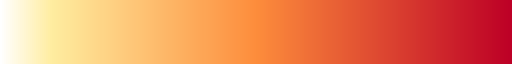

In [35]:
colors = [(0.0, "#ffffff"), (0.1, "#ffeda0"), (0.5, "#fd8d3c"), (1, "#bd0026")] 
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
cmap

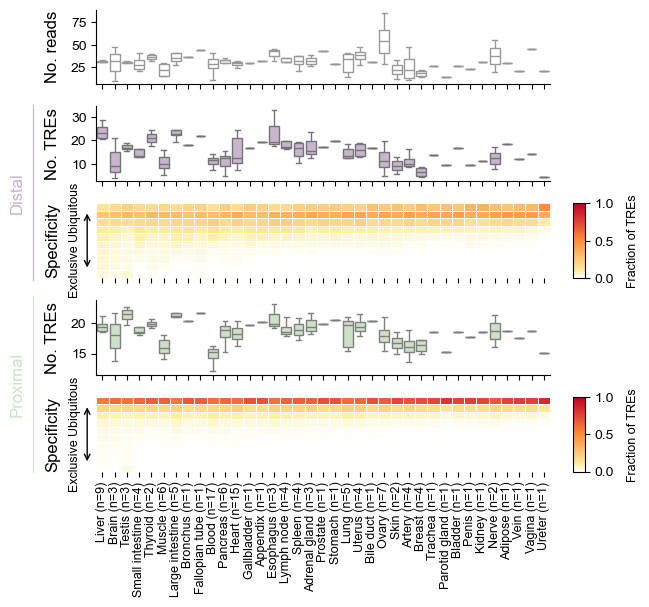

In [72]:
fig, ax = plt.subplots(5,2,figsize=(6.3,6), gridspec_kw={"width_ratios": [20,0.5]})

for i in range(5):
	if i not in [2,4]:
		ax[i,1].axis("off")

# Reads
g = sns.boxplot(data=df_info, x="tissue", y="reads", color="#ffffff",
				order=order, showfliers=False, ax=ax[0,0]
		 )

for d in ds:
	# No. elements
	g = sns.boxplot(data=df_info, x="tissue", y=d, color=palette[ds.index(d)],
		  order=order, showfliers=False, ax=ax[2*(ds.index(d))+1,0]
		 )
	# Specificity
	g = sns.heatmap(data=df_frac[d][order], cmap=cmap, linewidth=.5,
							yticklabels=False, xticklabels=True,
							cbar=False, vmin=0, vmax=1,
							ax=ax[2*(ds.index(d)+1),0])
	cbar = g.figure.colorbar(g.collections[0], cax=ax[2*(ds.index(d)+1),1])
	cbar.set_label("Fraction of TREs", fontsize=sfontsize, labelpad=10)
	trans = g.get_yaxis_transform()
	g.annotate("Ubiquitous", xy=(-0.05, 1), xycoords=trans, ha="center", va="center", fontsize=sfontsize, rotation=90)
	g.annotate("Exclusive", xy=(-0.05, 9), xycoords=trans, ha="center", va="center", fontsize=sfontsize, rotation=90)
	arrow = patches.FancyArrowPatch(
		(-0.02, 9), 
		(-0.02, 1), 
		arrowstyle='<->',        
		mutation_scale=10, 
		transform=trans,    
		clip_on=False       
	)
	g.add_patch(arrow)

ylabels = ["No. reads"] + ["No. TREs", "Specificity"]*2 
for n in range(5):
	ax[n,0].set_ylabel(ylabels[n], fontsize=bfontsize)
	ax[n,0].yaxis.set_label_coords(-0.08, 0.5)
	ax[n,0].spines[["top", "right"]].set_visible(False)
	ax[n,0].set_xlabel("")
	if n != 4:
		ax[n,0].set_xticklabels([])
	else:
		new_labels = []
		for tick in ax[n,0].get_xticklabels():
			t = tick.get_text()
			new_labels.append(f"{t} (n={len(types[t])})")
		ax[n,0].set_xticklabels(new_labels, rotation=90, fontsize=sfontsize)

for d in ds:
	row1, row2 = [2*(ds.index(d))+1,2*(ds.index(d)+1)]
	y_center = (ax[row1,0].get_position().y0 + ax[row2,0].get_position().y1) / 2
	fig.text(0, y_center, d.capitalize(), va="center", ha="center", rotation="vertical", 
			 fontsize=bfontsize, c=palette[ds.index(d)])
	line = mlines.Line2D([0.025, 0.025], [ax[row1,0].get_position().y1, ax[row2,0].get_position().y0], transform=fig.transFigure,
                     color=palette[ds.index(d)], linewidth=lw, zorder=10)
	fig.add_artist(line)
	
fig.subplots_adjust(hspace=0.3, wspace=0.1)

plt.savefig(f"{PROJECT_DIR_o}figures/ExtDataFig3b.pdf", bbox_inches="tight", transparent=True)